In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader

In [13]:
device=torch.device("cuda")

import numpy as np
train_st=np.load('./processed_data/station/train.npy')
train_lab=np.load('./processed_data/labels/train_labels.npy')
test_st=np.load('./processed_data/station/test.npy')
test_lab=np.load('./processed_data/labels/test_labels.npy')
no2_train_sat=np.load('./processed_data/no2_train.npy')
o3_test_sat=np.load('./processed_data/o3_test.npy')
no2_test_sat=np.load('./processed_data/no2_test.npy')
o3_train_sat=np.load('./processed_data/o3_train.npy')



In [14]:
print(no2_train_sat.shape,o3_train_sat.shape)

satellite=np.stack((no2_train_sat,o3_train_sat),axis=0)
satellite=torch.tensor(satellite,dtype=torch.float32).to(device)
satellite_hourly=torch.repeat_interleave(satellite,24,dim=1)
satellite_hourly.shape

(730, 9, 10) (730, 9, 10)


torch.Size([2, 17520, 9, 10])

In [15]:
test_satellite=np.stack((no2_test_sat,o3_test_sat),axis=0)
test_satellite=torch.tensor(test_satellite,dtype=torch.float32).to(device)
test_satellite_hourly=torch.repeat_interleave(test_satellite,24,dim=1)
test_satellite_hourly.shape

torch.Size([2, 8784, 9, 10])

In [16]:
station=torch.tensor(train_st,dtype=torch.float32).to(device)
print(station.shape)

labels=torch.tensor(train_lab,dtype=torch.float32).to(device)
labels=labels[12:]
print(labels.shape)

satellite_hourly_seq=satellite_hourly.unfold(dimension=1,size=12,step=1).permute(1,4,0,2,3)
station_seq=station.unfold(dimension=0,size=12,step=1)
satellite_hourly_seq=satellite_hourly_seq[:-1,...]
station_seq=station_seq[:-1,...]
station_seq=station_seq.permute(0,2,1)
print(satellite_hourly_seq.shape)
print(station_seq.shape)


torch.Size([17520, 18])
torch.Size([17508, 2])
torch.Size([17508, 12, 2, 9, 10])
torch.Size([17508, 12, 18])


In [17]:
test_station=torch.tensor(test_st,dtype=torch.float32).to(device)
print(test_station.shape)

test_labels=torch.tensor(test_lab,dtype=torch.float32).to(device)
test_labels=test_labels[12:]
print(test_labels.shape)

test_satellite_hourly_seq=test_satellite_hourly.unfold(dimension=1,size=12,step=1).permute(1,4,0,2,3)
test_station_seq=test_station.unfold(dimension=0,size=12,step=1)
test_satellite_hourly_seq=test_satellite_hourly_seq[:-1,...]
test_station_seq=test_station_seq[:-1,...]
test_station_seq=test_station_seq.permute(0,2,1)
print(test_satellite_hourly_seq.shape)
print(test_station_seq.shape)


torch.Size([8784, 18])
torch.Size([8772, 2])
torch.Size([8772, 12, 2, 9, 10])
torch.Size([8772, 12, 18])


In [18]:
labels_mean = labels.mean(dim=0)      # [2] -> mean of O3, NO2
labels_std = labels.std(dim=0)        # [2] -> std of O3, NO2

labels_scaled = (labels - labels_mean) / labels_std

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNNEncoder(nn.Module):
    """Encodes spatial satellite grids into a compact feature vector."""
    def __init__(self, in_channels=2, output_size=32):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # NOTE: flatten size depends on input H×W
        self.flatten_size = 32 * (9 // 2) * (10 // 2)  # after pooling
        self.fc = nn.Linear(self.flatten_size, output_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        return torch.tanh(self.fc(x))


# class LinearEncoder(nn.Module):
#     """Flattens spatial grid directly to a feature vector (baseline encoder)."""
#     def __init__(self, in_channels=2, grid_size=(9, 10), output_size=32):
#         super().__init__()
#         input_size = in_channels * grid_size[0] * grid_size[1]
#         self.fc = nn.Linear(input_size, output_size)

#     def forward(self, x):
#         x = torch.flatten(x, start_dim=1)
#         return self.fc(x)

# class BahdanauAttention(nn.Module):
#     """Additive (Bahdanau-style) attention over LSTM outputs."""
#     def __init__(self, hidden_size, attn_dim=64):
#         super().__init__()
#         # Projects hidden state into attention space
#         self.W = nn.Linear(hidden_size, attn_dim)
#         # Scoring vector u0
#         self.v = nn.Linear(attn_dim, 1, bias=False)
#         # Optional bias term d_j is already absorbed in nn.Linear

#     def forward(self, lstm_out):
#         """
#         lstm_out: [batch, seq_len, hidden_size]
#         """
#         # 1. Project hidden states with tanh nonlinearity
#         energy = torch.tanh(self.W(lstm_out))           # [batch, seq_len, attn_dim]

#         # 2. Compute scores for each timestep
#         scores = self.v(energy).squeeze(-1)             # [batch, seq_len]

#         # 3. Normalize to get attention weights
#         weights = torch.softmax(scores, dim=1)          # [batch, seq_len]

#         # 4. Weighted sum of hidden states
#         context = torch.bmm(weights.unsqueeze(1), lstm_out)  # [batch, 1, hidden_size]

#         return context.squeeze(1), weights 
    

class FusionModel(nn.Module):
    """Fuses CNN-encoded satellite data with station features, then forecasts pollutants."""
    def __init__(
        self,
        sat_channels=2,
        station_features=18,
        cnn_out=64,
        lstm_hidden=64,
        lstm_layers=1,
        dropout=0.15
    ):
        super().__init__()

        # Choose encoder
        self.cnn = CNNEncoder(in_channels=sat_channels, output_size=cnn_out)
        # self.cnn = LinearEncoder(in_channels=sat_channels, output_size=cnn_out)

        self.attn_o3 = BahdanauAttention(lstm_hidden)
        self.attn_no2=BahdanauAttention(lstm_hidden)

        lstm_input_size = cnn_out + station_features
        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )
        lstm_input_size = cnn_out + station_features
        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )

        # Heads for O3 and NO2
        self.head_O3 = nn.Linear(lstm_hidden, 1)
        self.head_NO2 = nn.Linear(lstm_hidden, 1)

    def forward(self, sat_x, station_x):
        """
        sat_x: [batch, seq_len, channels, H, W]
        station_x: [batch, seq_len, station_features]
        """
        batch_size, seq_len, _, _, _ = sat_x.shape

        # Encode each time step
        cnn_embeds = []
        for t in range(seq_len):
            sat_frame = sat_x[:, t]  # [batch, channels, H, W]
            cnn_embeds.append(self.cnn(sat_frame))
        cnn_embeds = torch.stack(cnn_embeds, dim=1)  # [batch, seq_len, cnn_out]

        # Fuse with station features
        lstm_in = torch.cat((cnn_embeds, station_x), dim=2)

        # Temporal modeling
        lstm_out, (hn, cn) = self.lstm(lstm_in)
        final_state = hn[-1]  # [batch, lstm_hidden]

        # Predict O3 and NO2
        pred_o3 = self.head_O3(final_state)
        pred_no2 = self.head_NO2(final_state)

        return torch.cat((pred_no2,pred_o3), dim=1)  # [batch, 2]



In [20]:
import torch.optim as optim

sat_data=satellite_hourly_seq #[17508, 12, 2, 9, 10])
station_data=station_seq #[17508, 16, 12]
labels=labels_scaled # ([17508, 2])
# Create Dataset and DataLoader
dataset = TensorDataset(sat_data, station_data, labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# ======================
# Init model + optimizer
# ======================
model = FusionModel(
    sat_channels=2,
    station_features=18,   # match your station features
    cnn_out=64,
    lstm_hidden=128,
    lstm_layers=2,
    dropout=0.15
).to(device)

criterion = nn.MSELoss()       # regression forecasting
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# ====================
# Training Loop
# ====================
epochs = 50

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for sat_batch, station_batch, y_batch in dataloader:
        sat_batch = sat_batch.to(device, dtype=torch.float32)
        station_batch = station_batch.to(device, dtype=torch.float32)
        y_batch = y_batch.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        preds = model(sat_batch, station_batch)  # [batch, 2]

        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * sat_batch.size(0)

    avg_loss = epoch_loss / len(dataset)
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

Epoch [1/50] Loss: 0.2308
Epoch [2/50] Loss: 0.1226
Epoch [3/50] Loss: 0.1120
Epoch [4/50] Loss: 0.1052
Epoch [5/50] Loss: 0.1008
Epoch [6/50] Loss: 0.0968
Epoch [7/50] Loss: 0.0940
Epoch [8/50] Loss: 0.0907
Epoch [9/50] Loss: 0.0883
Epoch [10/50] Loss: 0.0856
Epoch [11/50] Loss: 0.0817
Epoch [12/50] Loss: 0.0800
Epoch [13/50] Loss: 0.0787
Epoch [14/50] Loss: 0.0758
Epoch [15/50] Loss: 0.0723
Epoch [16/50] Loss: 0.0699
Epoch [17/50] Loss: 0.0675
Epoch [18/50] Loss: 0.0651
Epoch [19/50] Loss: 0.0618
Epoch [20/50] Loss: 0.0604
Epoch [21/50] Loss: 0.0571
Epoch [22/50] Loss: 0.0550
Epoch [23/50] Loss: 0.0522
Epoch [24/50] Loss: 0.0496
Epoch [25/50] Loss: 0.0474
Epoch [26/50] Loss: 0.0451
Epoch [27/50] Loss: 0.0434
Epoch [28/50] Loss: 0.0411
Epoch [29/50] Loss: 0.0387
Epoch [30/50] Loss: 0.0376
Epoch [31/50] Loss: 0.0354
Epoch [32/50] Loss: 0.0335
Epoch [33/50] Loss: 0.0330
Epoch [34/50] Loss: 0.0314
Epoch [35/50] Loss: 0.0303
Epoch [36/50] Loss: 0.0289
Epoch [37/50] Loss: 0.0275
Epoch [38/

In [21]:
import torch


def evaluate(model, dataloader, device):
    model.eval()
    preds_list, labels_list = [], []

    with torch.no_grad():
        for sat_batch, station_batch, y_batch in dataloader:
            sat_batch = sat_batch.to(device, dtype=torch.float32)
            station_batch = station_batch.to(device, dtype=torch.float32)
            y_batch = y_batch.to(device, dtype=torch.float32)

            preds = model(sat_batch, station_batch)  # [batch, 2]

            preds_list.append(preds.cpu())
            labels_list.append(y_batch.cpu())

    # Concatenate
    preds_all = torch.cat(preds_list, dim=0)   # [N, 2]
    labels_all = torch.cat(labels_list, dim=0) # [N, 2]

    metrics = {}
    for i, name in enumerate(["NO2","O3"]):
        y_true = labels_all[:, i]
        y_pred = preds_all[:, i]

        mse = torch.mean((y_true - y_pred) ** 2).item()
        rmse = torch.sqrt(torch.mean((y_true - y_pred) ** 2)).item()
        mae = torch.mean(torch.abs(y_true - y_pred)).item()

        # R² = 1 - SS_res / SS_tot
        ss_res = torch.sum((y_true - y_pred) ** 2)
        ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else float("nan")

        metrics[name] = {
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2.item() if isinstance(r2, torch.Tensor) else r2
        }

    return metrics


In [22]:
sat_data=test_satellite_hourly_seq #[17508, 12, 2, 9, 10])
station_data=test_station_seq #[17508, 16, 12]
test_labels_scaled = (test_labels - labels_mean) / labels_std
labels=test_labels_scaled # ([17508, 2])

test_dataset = TensorDataset(sat_data, station_data, labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



val_metrics = evaluate(model, test_loader, device)

print(f"O3  → MSE: {val_metrics['O3']['MSE']:.2f}, "
      f"RMSE: {val_metrics['O3']['RMSE']:.2f}, "
      f"MAE: {val_metrics['O3']['MAE']:.2f}, "
      f"R2: {val_metrics['O3']['R2']:.3f}")

print(f"NO2 → MSE: {val_metrics['NO2']['MSE']:.2f}, "
      f"RMSE: {val_metrics['NO2']['RMSE']:.2f}, "
      f"MAE: {val_metrics['NO2']['MAE']:.2f}, "
      f"R2: {val_metrics['NO2']['R2']:.3f}")


O3  → MSE: 0.19, RMSE: 0.43, MAE: 0.30, R2: 0.583
NO2 → MSE: 0.16, RMSE: 0.39, MAE: 0.28, R2: 0.877


In [23]:
import torch
import matplotlib.pyplot as plt

def evaluate_and_plot(model, test_loader, device):
    model.eval()
    preds_list, labels_list = [], []

    with torch.no_grad():
        for sat_batch, station_batch, y_batch in test_loader:
            sat_batch = sat_batch.to(device, dtype=torch.float32)
            station_batch = station_batch.to(device, dtype=torch.float32)
            y_batch = y_batch.to(device, dtype=torch.float32)

            preds = model(sat_batch, station_batch)  # [batch, 2]

            preds_list.append(preds.cpu())
            labels_list.append(y_batch.cpu())

    # Concatenate across all batches
    preds_all = torch.cat(preds_list, dim=0)   # [N, 2]
    labels_all = torch.cat(labels_list, dim=0) # [N, 2]

    # ====== Plot for O3 ======
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(labels_all[:, 1], preds_all[:, 1], alpha=0.5, s=10)
    plt.plot(
        [labels_all[:, 1].min(), labels_all[:, 1].max()],
        [labels_all[:, 1].min(), labels_all[:, 1].max()],
        'r--'
    )
    plt.xlabel("Actual O3")
    plt.ylabel("Predicted O3")
    plt.title("O3: Predicted vs Actual")

    # ====== Plot for NO2 ======
    plt.subplot(1, 2, 2)
    plt.scatter(labels_all[:, 0], preds_all[:, 0], alpha=0.5, s=10, color="orange")
    plt.plot(
        [labels_all[:, 0].min(), labels_all[:, 0].max()],
        [labels_all[:, 0].min(), labels_all[:, 0].max()],
        'r--'
    )
    plt.xlabel("Actual NO2")
    plt.ylabel("Predicted NO2")
    plt.title("NO2: Predicted vs Actual")

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(labels_all[:, 1], label="Actual O₃", alpha=0.8)
    plt.plot(preds_all[:, 1], label="Predicted O₃", alpha=0.8)
    plt.legend()
    plt.title("O₃: Predicted vs Actual")
    plt.xlabel("Time step")
    plt.ylabel("O₃ (µg/m³)")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(labels_all[:, 0], label="Actual NO2", alpha=0.8)
    plt.plot(preds_all[:, 0], label="Predicted NO2", alpha=0.8)
    plt.legend()
    plt.title("NO2: Predicted vs Actual")
    plt.xlabel("Time step")
    plt.ylabel("NO2 (µg/m³)")
    plt.grid(True)
    plt.show()
    return preds_all, labels_all


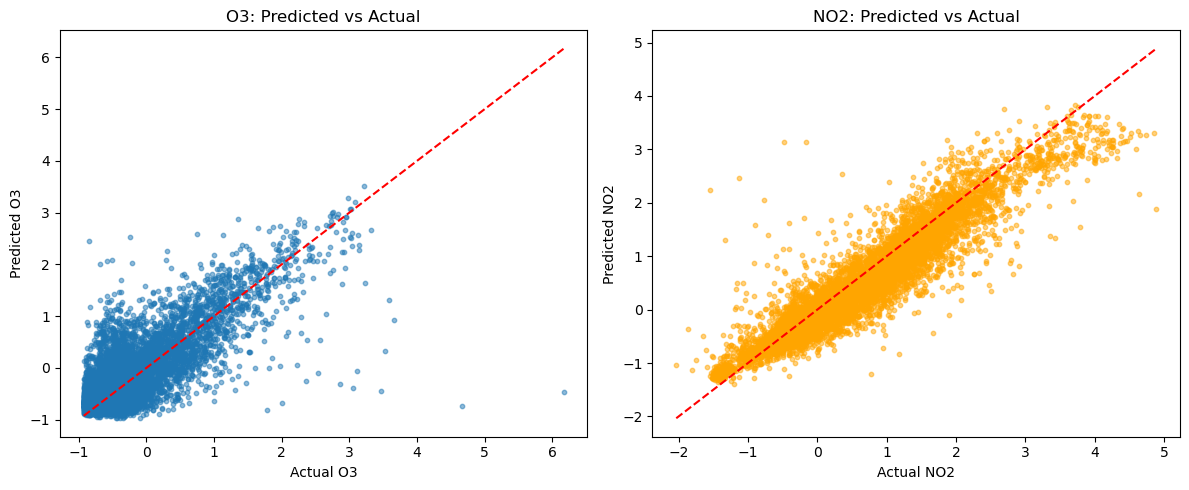

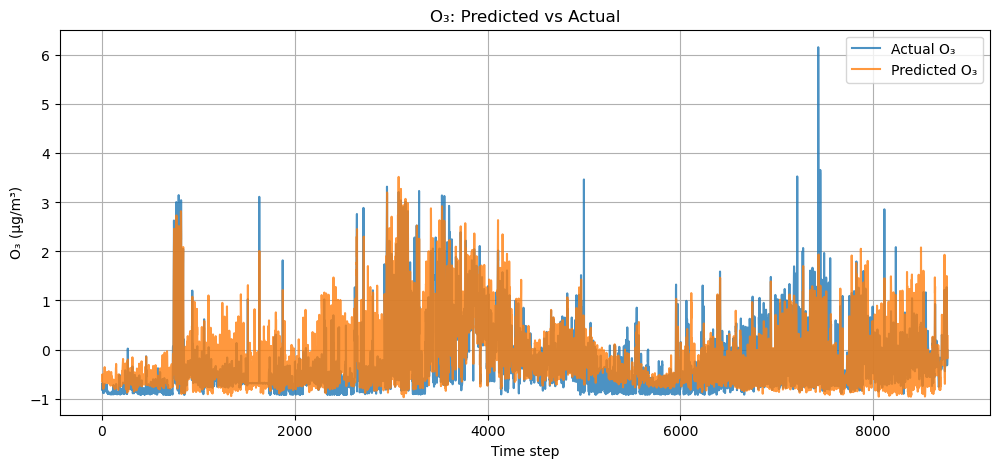

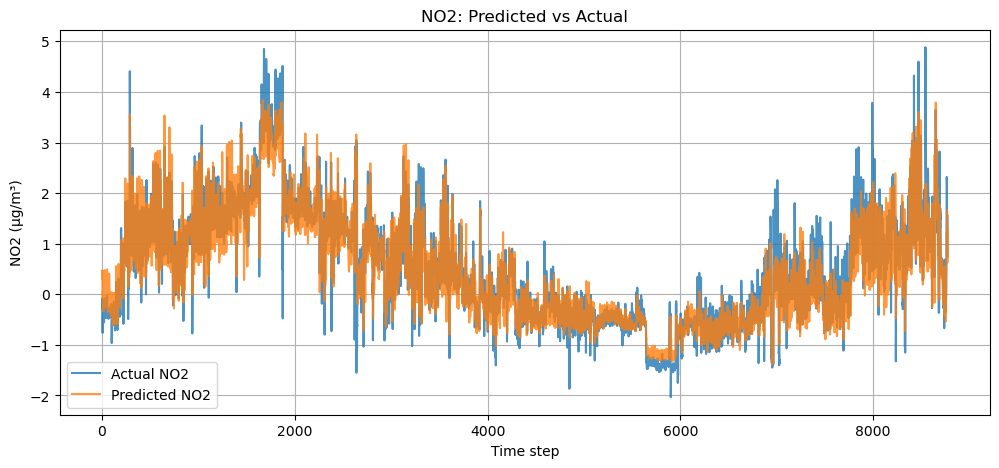

In [24]:
preds_all, labels_all = evaluate_and_plot(model, test_loader, device)
